In [1]:
import os, random, glob
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model, load_model
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
from skimage.data import imread
from skimage.io import imshow,imsave
from skimage import img_as_float
import pandas as pd
import numpy as np
import cv2
from skimage.util import crop
from skimage.transform import rotate
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [3]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../data/test_stg1/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
modelStr = 'Crop'
ROWS = 224
COLS = 224
BatchSize = 64
LearningRate = 1e-4
le = LabelEncoder()
le.fit(FISH_CLASSES)
le.transform(FISH_CLASSES)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [4]:
#生成图像随机变换矩阵
#modified from code https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

def transform_matrix_offset_center(matrix, w, h):
    center_x = float(w) / 2 + 0.5
    center_y = float(h) / 2 + 0.5
    #图像center移到原点，进行rotation和shear
    offset_matrix = np.array([[1, 0, center_x], [0, 1, center_y], [0, 0, 1]])
    #移回来
    reset_matrix = np.array([[1, 0, -center_x], [0, 1, -center_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(reset_matrix, matrix), offset_matrix)
    return transform_matrix

def random_transform_matrix(image,
                            rotation_range=0.,
                            width_shift_range=0.,
                            height_shift_range=0.,
                            shear_range=0.,
                            zoom_range=0.,
                            horizontal_flip=False,
                            vertical_flip=False):
    
    h, w = image.shape[0], image.shape[1]
       
    #图像上下翻转
    hflip_matrix=np.eye(3)
    if horizontal_flip:
        if np.random.random() < 0.5:
            print("horizontal_flip")
            hflip_matrix = np.array([[-1, 0, w],
                                     [0, 1, 0],
                                     [0, 0, 1]])
    #图像左右翻转                              
    vflip_matrix=np.eye(3)
    if vertical_flip:
        if np.random.random() < 0.5:
            print("vertical_flip")
            vflip_matrix = np.array([[1, 0, 0],
                                     [0, -1, h],
                                     [0, 0, 1]])
    #图像顺时针旋转theta       
    if rotation_range:
        theta = np.pi / 180 * np.random.uniform(-rotation_range, rotation_range)
    else:
        theta = 0
    print("theta =",theta)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    
    #图像往正轴移动tx，ty
    if height_shift_range:
        ty = np.random.uniform(-height_shift_range, height_shift_range) * h
    else:
        ty = 0

    if width_shift_range:
        tx = np.random.uniform(-width_shift_range, width_shift_range) * w
    else:
        tx = 0
    print("tx =",tx)
    print("ty =",ty)
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    
    #图像顺时针shear
    if shear_range:
        shear = np.random.uniform(-shear_range, shear_range)
    else:
        shear = 0
    print("shear =",shear)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])
    
    #以center为中心图像放大zx，zy
    if np.isscalar(zoom_range):
        zoom_range = [1 - zoom_range, 1 + zoom_range]
    elif len(zoom_range) == 2:
        zoom_range = [zoom_range[0], zoom_range[1]]
    else:
        raise ValueError('zoom_range should be a float or '
                         'a tuple or list of two floats. '
                         'Received arg: ', zoom_range)
            
    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    print("zx =",zx)
    print("zy =",zy)
    zoom_matrix = np.array([[zx, 0, (1-zx)*w/2.],
                            [0, zy, (1-zy)*h/2.],
                            [0, 0, 1]])
    #transform_matrix = zoom_matrix
    transform_matrix = np.dot(shear_matrix, rotation_matrix)
    transform_matrix = transform_matrix_offset_center(transform_matrix, w, h)
    transform_matrix = np.dot(np.dot(np.dot(np.dot(translation_matrix, 
                                                   zoom_matrix), 
                                            transform_matrix), 
                                     vflip_matrix), 
                              hflip_matrix)
    return transform_matrix[:2,:]

img_00003.jpg


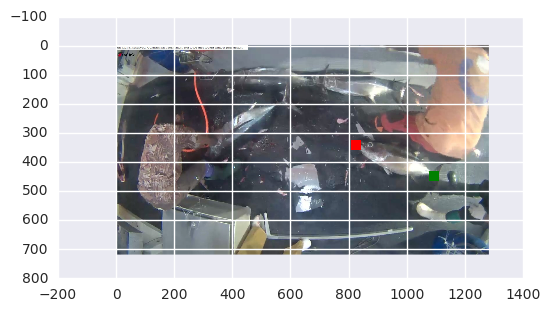

In [5]:
labels = pd.read_json('../data/annotation/alb_labels.json')
img_filename = labels.iloc[1,2]
print(img_filename)
l1 = pd.DataFrame((labels[labels.filename==img_filename].annotations).iloc[0])
x_head = l1.iloc[0,1]
y_head = l1.iloc[0,2]
x_tail = l1.iloc[1,1]
y_tail = l1.iloc[1,2]

image = imread(TRAIN_DIR+'ALB/'+img_filename)
rescale = 1./255,
image = image*rescale
h, w = image.shape[0], image.shape[1]

plt.imshow(image)
plt.plot(x_head, y_head,'rs')
plt.plot(x_tail, y_tail,'gs')

horizontal_flip
theta = 0.05210557806613641
tx = -77.3380875056192
ty = -47.128004591295024
shear = 0.1984940631578947
zx = 1.00064377265
zy = 1.08922913844


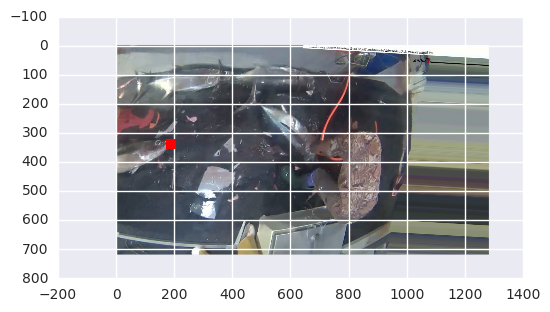

In [6]:
M = random_transform_matrix(image,
                            rotation_range=20,
                            shear_range=0.2,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True)
image_transformed = cv2.warpAffine(image, M, (w, h), borderMode=1)
head_transformed = np.dot(M,np.array([x_head,y_head,1]))
tail_transformed = np.dot(M,np.array([x_tail,y_tail,1]))
x_head_transformed = head_transformed[0]
y_head_transformed = head_transformed[1]
x_tail_transformed = tail_transformed[0]
y_tail_transformed = tail_transformed[1]

plt.imshow(image_transformed)
if 0<=x_head_transformed<=w and 0<=y_head_transformed<=h:
    plt.plot(x_head_transformed, y_head_transformed,'rs')
if 0<=x_tail_transformed<=w and 0<=y_tail_transformed<=h:
    plt.plot(x_tail_transformed, y_tail_transformed,'gs')


In [ ]:
center = ( (x_head_transformed+x_tail_transformed) / 2,(y_head_transformed+y_tail_transformed) / 2)
fish_length = np.sqrt((x_tail_transformed-x_head_transformed)**2+
                      (y_tail_transformed-y_head_transformed)**2)
image_cropped = image_transformed[(max((center[1]-fish_length/1.8),0)):(max((center[1]+fish_length/1.8),0)) ,
                  (max((center[0]- fish_length/1.8),0)):(max((center[0]+fish_length/1.8),0))]

plt.imshow(image_cropped)

In [ ]:
image_resized = resize(image_transformed,(ROWS,COLS))
plt.imshow(image_resized)
x_ratio = float(COLS)/w
y_ratio = float(ROWS)/h
print(x_ratio,y_ratio)
head_resized = [head_transformed[0]*x_ratio,head_transformed[1]*y_ratio]
tail_resized = [tail_transformed[0]*x_ratio,tail_transformed[1]*y_ratio]
plt.plot(head_resized[0], head_resized[1],'rs')
plt.plot(tail_resized[0], tail_resized[1],'gs')

In [ ]:
model.train_on_batch(self, x, y, class_weight=None, sample_weight=None)

In [ ]:
def deg_angle_between(x1,y1,x2,y2):
    from math import atan2, degrees, pi
    dx = x2 - x1
    dy = y2 - y1
    rads = atan2(dy,dx)
    #rads %= 2*pi
    degs = degrees(rads)
    return(degs)

def get_rotated_cropped_fish(image,x1,y1,x2,y2):
    (h,w) = image.shape[:2]
    #calculate center and angle
    center = ( (x1+x2) / 2,(y1+y2) / 2)
    angle = np.floor(deg_angle_between(x1,y1,x2,y2))
    #print('angle=' +str(angle) + ' ')
    #print('center=' +str(center))
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    
    fish_length = np.sqrt((x1-x2)**2+(y1-y2)**2)
    cropped = rotated[(max((center[1]-fish_length/1.8),0)):(max((center[1]+fish_length/1.8),0)) ,
                      (max((center[0]- fish_length/1.8),0)):(max((center[0]+fish_length/1.8),0))]
    #imshow(image)
    #imshow(rotated)
    #imshow(cropped)
    resized = resize(cropped,(ROWS,COLS))
    return(resized)

In [ ]:
#Loading data

import pickle

if os.path.exists('../data/data_train_annoCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_train_annoCrop_{}_{}.pickle. Loading data from file.'.format(ROWS, COLS))
    with open('../data/data_train_annoCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_train = pickle.load(f)
    X_train = data_train['X_train']
    y_train = data_train['y_train']
    del data_train
else:
    print ('Loading data from original images. Generating data_train_annoCrop_{}_{}.pickle.'.format(ROWS, COLS))
    
    images = []
    y_train = []

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')
    crop_classes

    for c in crop_classes:
        labels = pd.read_json('../data/annotation/'+c.lower()+'_labels.json')
        for i in range(len(labels)):
            try:
                img_filename = labels.iloc[i,2]
                print(img_filename)
                l1 = pd.DataFrame((labels[labels.filename==img_filename].annotations).iloc[0])
                image = imread(TRAIN_DIR+c+'/'+img_filename)
                images.append(get_rotated_cropped_fish(image,np.floor(l1.iloc[0,1]),np.floor(l1.iloc[0,2]),np.floor(l1.iloc[1,1]),np.floor(l1.iloc[1,2])))
                print('success')
                y_train.append(c)
            except:
                pass

    X_train = np.asarray(images, dtype=np.float32)

    # One Hot Encoding Labels
    y_train = le.transform(y_train)
    y_train = np_utils.to_categorical(y_train)

    #save data to file
    data_train = {'X_train': X_train,'y_train': y_train }

    with open('../data/data_train_annoCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_train, f)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=None, stratify=y_train)

In [ ]:
#data preprocessing

train_datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

#train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BatchSize, shuffle=True, seed=None)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=BatchSize, shuffle=True, seed=None)

In [ ]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath='./checkpoints/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)


In [ ]:
#stg1 training

from keras.applications.vgg16 import VGG16

optimizer = Adam(lr=LearningRate)

base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
hist = model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [ ]:
#stg2 training

from keras.applications.vgg16 import VGG16

optimizer = Adam(lr=LearningRate)

base_model = VGG16(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:14]:
   layer.trainable = False
for layer in model.layers[14:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hist = model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [ ]:
#resume training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

hist = model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [ ]:
#test submission

import datetime

if os.path.exists('../data/data_test_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_test_{}_{}.pickle. Loading test data from file.'.format(ROWS, COLS))
    with open('../data/data_test_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_test = pickle.load(f)
    X_test = data_test['X_test']
    test_files = data_test['test_files']
else:
    print ('Loading test data from original images. Generating data_test_{}_{}.pickle.'.format(ROWS, COLS))

    test_files = [im for im in os.listdir(TEST_DIR)]
    X_test = np.ndarray((len(test_files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(test_files): 
        X_test[i] = read_image(TEST_DIR+im)
        if i%300 == 0: print('Processed {} of {}'.format(i, len(test_files)))
            
    data_test = {'X_test': X_test,'test_files': test_files }
    
    with open('../data/data_test_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_test, f)
            
X_test = X_test / 255.

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
model = load_model(files[index])

test_preds = model.predict(X_test, batch_size=BatchSize, verbose=1)
#test_preds= test_preds / np.sum(test_preds,axis=1,keepdims=True)

submission = pd.DataFrame(test_preds, columns=FISH_CLASSES)
#submission.loc[:, 'image'] = pd.Series(test_files, index=submission.index)
submission.insert(0, 'image', test_files)

now = datetime.datetime.now()
info = modelStr + '{:.4f}'.format(min(val_losses))
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
submission.to_csv(sub_file, index=False)

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()